In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import cv2
import imageio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import torch
import cmath
from run_VAE import sites_NOVEMBER, RAW_NOVEMBER, INTERMEDIATE_NOVEMBER
from HiddenStateExtractor.cv2_feature import get_density, get_angle_apr, get_aspect_ratio_no_rotation
from HiddenStateExtractor.vq_vae import VQ_VAE, rescale

/data/michaelwu/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/data/michaelwu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
RAW_NOVEMBER = '/mnt/comp_micro/Projects/learningCellState/microglia/raw_for_segmentation/NOVEMBER/raw'
INTERMEDIATE_NOVEMBER = '/mnt/comp_micro/Projects/learningCellState/microglia/raw_for_segmentation/NOVEMBER/supp'

In [3]:
plt.switch_backend('module://ipykernel.pylab.backend_inline')

In [4]:
### Define Extra Functions ###

phase_a = 2.
phase_b = -50000.

sites = sites_NOVEMBER
# {'B4', 'B5', 'C4', 'B2', 'C5'}
wells = {'B4', 'B5', 'B2', 'C5', 'C4'}
wells_ = {'B4', 'B5', 'B2', 'C5'}
raw_folder = RAW_NOVEMBER
supp_folder = INTERMEDIATE_NOVEMBER

legends = {
    'B2': 'Glioblastoma',
    'B4': 'IL17',
    'B5': 'IFN beta',
    'C4': 'Rubella',
    'C5': 'Control'
}

def hex_to_rgb(s):
    s = s.lstrip('#')
    s = list(int(s[i:i+2], 16)/256. for i in (0, 2, 4)) + [1.] # hex to rgb
    return s

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def generate_color_vectors(start, end, N=256):
    start = hex_to_rgb(start)
    end = hex_to_rgb(end)
    output = np.zeros((N, 4))
    for i in range(4):
        output[:, i] = np.linspace(start[i], end[i], N)
    return output

cmaps = {
    'B2': ListedColormap(generate_color_vectors('#ffffff', '#438548')),
    'B4': ListedColormap(generate_color_vectors('#ffffff', '#ce103d')),
    'B5': ListedColormap(generate_color_vectors('#ffffff', '#d44d00')),
    'C4': ListedColormap(generate_color_vectors('#ffffff', '#f0ba00')),
    'C5': ListedColormap(generate_color_vectors('#ffffff', '#005082')),
    'all': ListedColormap(generate_color_vectors('#ffffff', '#111111'))
}

colors = {w: cmaps[w](0.8) for w in cmaps}

def enhance_contrast(mat, a=1.5, b=-10000):
  mat2 = cv2.addWeighted(mat, a, mat, 0, b)
  return mat2

def save_movie(traj, path):
  well = traj[:2]
  stacks = []
  for ind in traj_inds[traj]:
    mat = (site_dat.tensors[0][ind][0].data.numpy() * 65535).astype('uint16')
    mat2 = np.clip(enhance_contrast(mat, phase_a, phase_b), 0, 65535).astype('uint16')
    stacks.append(mat2)
  output = (np.stack(stacks, 0).astype('float')/256).astype('uint8')
  imageio.mimsave(path, output)

def save_traj_bbox(traj, path):
  output_images = np.zeros((len(traj_inds[traj]), 512, 512))
  site = traj.split('/')[0]
  image_stack = np.load(os.path.join(raw_folder, '%s.npy' % site))
  for i, k in enumerate(sorted(trajs[traj].keys())):
    mat = cv2.resize(image_stack[k, :, :, 0], (512, 512))
    output_images[i] = np.clip(enhance_contrast(mat, phase_a, phase_b), 0, 65535).astype('uint16')

  output_images = np.stack([output_images] * 3, 3)
  output_images = output_images / 65535.

  for i, k in enumerate(sorted(trajs[traj].keys())):
    box_center = traj_positions[traj][k] / (2048/512)
    box_range = [(max(box_center[0] - 16., 0), min(box_center[0] + 16., 512)),
                 (max(box_center[1] - 16., 0), min(box_center[1] + 16., 512))]
    
    # Left edge
    x = box_range[0][0]
    x_ = (int(max(x - 1., 0)), int(min(x + 1., 512)))
    output_images[i, x_[0]:x_[1], int(box_range[1][0]):int(box_range[1][1])] = np.array([1., 0., 0.]).reshape((1, 1, 3))
    # Right edge
    x = box_range[0][1]
    x_ = (int(max(x - 1., 0)), int(min(x + 1., 512)))
    output_images[i, x_[0]:x_[1], int(box_range[1][0]):int(box_range[1][1])] = np.array([1., 0., 0.]).reshape((1, 1, 3))
    # Top edge
    y = box_range[1][0]
    y_ = (int(max(y - 1., 0)), int(min(y + 1., 512)))
    output_images[i, int(box_range[0][0]):int(box_range[0][1]), y_[0]:y_[1]] = np.array([1., 0., 0.]).reshape((1, 1, 3))
    # Bottom edge
    y = box_range[1][1]
    y_ = (int(max(y - 1., 0)), int(min(y + 1., 512)))
    output_images[i, int(box_range[0][0]):int(box_range[0][1]), y_[0]:y_[1]] = np.array([1., 0., 0.]).reshape((1, 1, 3))
  # tifffile.imwrite(path, (output_images*255).astype('uint8'))
  imageio.mimwrite(path, (output_images*255).astype('uint8'))
  return

def plot_joint_density(x, y, df, bins_x, bins_y, cmap='Blues'):
    g = sns.JointGrid(x=x, y=y, data=df, ylim=(bins_y[0], bins_y[-1]), xlim=(bins_x[0], bins_x[-1]))
    _ = g.ax_marg_x.hist(df[x], bins=bins_x, color=cmap(0.8))
    _ = g.ax_marg_y.hist(df[y], bins=bins_y, orientation='horizontal', color=cmap(0.8))
    g.plot_joint(plt.hexbin, cmap=cmap, gridsize=len(bins_x))

def plot_joint_kde(x, y, df, bins_x, bins_y, cmap='Blues'):
    g = sns.JointGrid(x=x, y=y, data=df, ylim=(bins_y[0], bins_y[-1]), xlim=(bins_x[0], bins_x[-1]))
    _ = g.ax_marg_x.hist(df[x], bins=bins_x, color=cmap(0.8))
    _ = g.ax_marg_y.hist(df[y], bins=bins_y, orientation='horizontal', color=cmap(0.8))
    g.plot_joint(sns.kdeplot, cmap=cmap, shade=True)

In [ ]:
### Load All RAW Data ###
all_patches = {}
for well in wells:
    print(well)
    site_dat = torch.load(os.path.join(raw_folder, '%s_adjusted_static_patches.pt' % well))
    site_dat = rescale(site_dat)
    for i, f in enumerate(fs[well]):
        all_patches[f] = site_dat[i:(i+1)][0]

In [ ]:
### Load All Data ###
dats = {}
fs = {}
traj_inds = {}
trajs = {}
traj_positions = {}
for well in wells:
    path = os.path.join(raw_folder, '%s_latent_space_PCAed.pkl' % well)
    dats[well] = pickle.load(open(path, 'rb'))
    
    path = os.path.join(raw_folder, '%s_file_paths.pkl' % well)
    fs[well] = pickle.load(open(path, 'rb'))

    well_sites = [s for s in sites if s.startswith(well)]
    for site in well_sites:
        print(site)
        path = os.path.join(supp_folder, '%s-supps' % well, '%s' % site, 'cell_traj.pkl')
        cell_trajectories_inds, cell_trajectories_positions = pickle.load(open(path, 'rb'))

        path = os.path.join(supp_folder, '%s-supps' % well, '%s' % site, 'cell_pixel_assignments.pkl')
        cell_pixel_assignments = pickle.load(open(path, 'rb'))

        path = os.path.join(raw_folder, '%s_NNProbabilities.npy' % site)
        segmentation_stack = np.load(path)

        for i, (t, t_pos) in enumerate(zip(cell_trajectories_inds, cell_trajectories_positions)):
            traj_mg_ratios = []
            for t_point in t:
                cell_id = t[t_point]
                inds = np.where(cell_pixel_assignments[t_point][1] == cell_id)
                cell_pixels = cell_pixel_assignments[t_point][0][inds]
                cell_segmentation = segmentation_stack[t_point][(cell_pixels[:, 0], cell_pixels[:, 1])]
                mg_ratio = (cell_segmentation[:, 1] > 0.5).sum() / cell_segmentation.shape[0]
                traj_mg_ratios.append(mg_ratio)
            if np.percentile(traj_mg_ratios, 0.2) > 0.8:
                # Confirmed as microglia
                trajs[site + '/%d' % i] = t
                traj_positions[site + '/%d' % i] = t_pos

    path = os.path.join(raw_folder, '%s_trajectories.pkl' % well)
    well_traj_inds = pickle.load(open(path, 'rb'))
    traj_inds.update({k: v for k, v in well_traj_inds.items() if k in trajs})

In [5]:
# with open('NOVEMBER_dat_save.pkl', 'wb') as f:
#     pickle.dump([dats, fs, traj_inds, trajs, traj_positions], f)
dats, fs, traj_inds, trajs, traj_positions = pickle.load(open('NOVEMBER_dat_save.pkl', 'rb'))

In [6]:
### Process Data and Generate Trajectory Summaries ###

t_lag = 1
bins_PC1 = np.linspace(-4, 6, 20)
bins_PC2 = np.linspace(-3, 8, 20)
bins_speed = np.linspace(1.0, 5.2, 20) # Log um/h scale

patch_PC1 = {well: dats[well][:, 0] for well in wells}
patch_PC2 = {well: dats[well][:, 1] for well in wells}

traj_PC1 = {well: [] for well in wells}
traj_PC2 = {well: [] for well in wells}
traj_speed = {well: [] for well in wells}
traj_names = {well: [] for well in wells}
for t in trajs:
    well = t[:2]
    if not well in wells:
        continue
    traj_names[well].append(t)
    traj_PC1[well].append(np.mean([dats[well][ind, 0] for ind in traj_inds[t]]))
    traj_PC2[well].append(np.mean([dats[well][ind, 1] for ind in traj_inds[t]]))

    t_keys = sorted(trajs[t].keys())
    dists = []
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            dists.append(d)    
    traj_speed[well].append(np.log(np.mean(dists) * 0.325 / 0.1518)) # Unit of pixel(0.325um) per frame(9.11 min) to um per hour

In [25]:
### Generate Traj Vectors ###

t_lag = 1
traj_vector_latent_vector = {}
traj_vector_motion = {}

# full_dats = {}
# for well in wells:
#     path = os.path.join(raw_folder, '%s_latent_space.pkl' % well)
#     full_dats[well] = pickle.load(open(path, 'rb'))

# Use K-way vectors
K = 5
for t in trajs:
    well = t[:2]
    if not well in wells:
        continue
    t_keys = sorted(trajs[t].keys())
    dists = []
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            dists.append(d) 
    #traj_full_dats = np.stack([full_dats[well][ind] for ind in traj_inds[t]], 0)
    traj_full_dats = np.stack([dats[well][ind] for ind in traj_inds[t]], 0)
    segs = np.linspace(0, len(traj_inds[t]), K+1).astype(int)
    vs = []
    ds = []
    for i in range(len(segs) - 1):
        #v = traj_full_dats[segs[i]:segs[i+1]].mean(0)
        v = traj_full_dats[np.random.randint(segs[i], segs[i+1])]
        vs.append(v)
        d = np.mean(dists[segs[i]:segs[i+1]])
        ds.append(d)
    traj_vector_latent_vector[t] = np.concatenate(vs)
    traj_vector_motion[t] = ds

/data/michaelwu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/michaelwu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


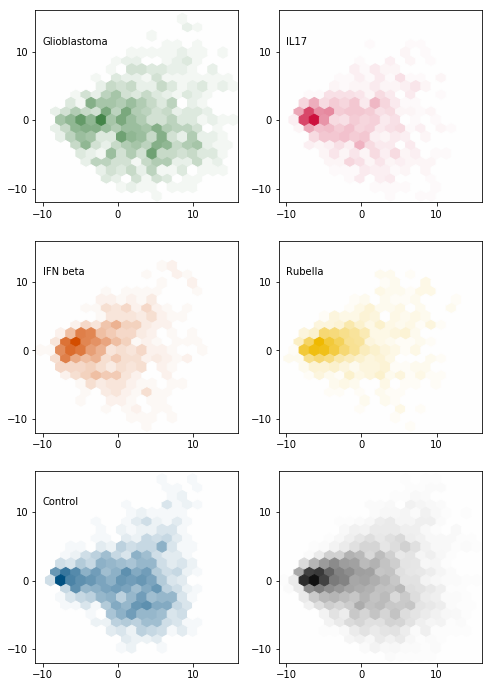

In [26]:
### PCA of traj vectors ###
from sklearn.decomposition import PCA
ts = sorted(trajs.keys())
traj_vectors = np.stack([traj_vector_latent_vector[t] for t in ts], 0)
pca = PCA(0.5)
pcaed = pca.fit_transform(traj_vectors)

well_inds = {w: [] for w in wells}
for i,t in enumerate(ts):
    well_inds[t[:2]].append(i)
for w in well_inds:
    well_inds[w] = np.array(well_inds[w])
    
fig, axs = plt.subplots(3, 2, figsize=(8, 12))

axs[-1][-1].hexbin(pcaed[:, 0], 
                   pcaed[:, 1], 
                   gridsize=20, 
                   extent=(-11, 16, -11, 16),
                   cmap=cmaps['all'])
axs[-1][-1].set_xlim(-11, 16)
axs[-1][-1].set_ylim(-12, 16)
axs[-1][-1].set_yticks([-10, 0, 10])
axs[-1][-1].set_xticks([-10, 0, 10])
for i, w in enumerate(sorted(wells)):
    axs[i//2][i%2].hexbin(pcaed[:, 0][well_inds[w]], 
                          pcaed[:, 1][well_inds[w]], 
                          gridsize=20, 
                          extent=(-11, 16, -11, 16),
                          cmap=cmaps[w])
    axs[i//2][i%2].set_xlim(-11, 16)
    axs[i//2][i%2].set_ylim(-12, 16)
    axs[i//2][i%2].set_yticks([-10, 0, 10])
    axs[i//2][i%2].set_xticks([-10, 0, 10])
    axs[i//2][i%2].text(-10, 11, legends[w])
# plt.show()
plt.savefig('traj_vec_rand_samples_pre_pca.png', dpi=300)

(array([0.37753966, 1.0417298 , 1.59871732, 1.7735042 , 1.69426748,
        1.4915147 , 1.07901766, 0.70846948, 0.48008129, 0.12584655]),
 array([0.00231666, 0.09874227, 0.19516789, 0.29159351, 0.38801912,
        0.48444474, 0.58087036, 0.67729598, 0.77372159, 0.87014721,
        0.96657283]),
 <a list of 10 Patch objects>)

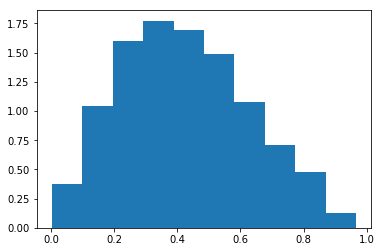

In [166]:
plt.hist(list(traj_orientation_stds.values()), normed=True)

In [169]:
### Calculate Cell Motion Directions ###

cell_aps = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_aspect_ratios.pkl'), 'rb'))
traj_orientations = {}
traj_orientation_stds = {}
patch_orientations = {}
patch_displacements = {}
t_lag = 1

angs1_all = []
angs2_all = []
ang_diffs_all = []
for t in traj_inds:
    well = t[:2]
    traj_fs = [fs[well][ind] for ind in traj_inds[t]]
    t_keys = sorted(trajs[t].keys())
    
    valid_fs = []
    ds = []
    d_angs = []
    for i, f in enumerate(traj_fs):
        t_point = t_keys[i]
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            d_ang = traj_positions[t][t_point+t_lag] - traj_positions[t][t_point]
            d_ang = cmath.polar(complex(d_ang[1], d_ang[0]))[1]
            valid_fs.append(f)
            ds.append(d)
            d_angs.append(d_ang)

    traj_cell_aps = [cell_aps[f][0] for f in valid_fs]
    traj_cell_angs = [cell_aps[f][1] for f in valid_fs]

    angs1 = [a for i, a in enumerate(d_angs) if traj_cell_aps[i] > 1.1] # Orientation of movement, 0 ~ 2pi
    angs2 = [a for i, a in enumerate(traj_cell_angs) if traj_cell_aps[i] > 1.1]
    angs2 = [a if a > 0 else a + np.pi for a in angs2] # Orientation of cell long axis, 0~pi
    angs1_all.extend(angs1)
    angs2_all.extend(angs2)
    ds = [d for i, d in enumerate(ds) if traj_cell_aps[i] > 1.1]
    valid_fs_ = [f for i, f in enumerate(valid_fs) if traj_cell_aps[i] > 1.1]
    if len(angs1) <= 2:
        continue
    
    ang_diffs = [(a1 - a2)%(np.pi) for a1, a2 in zip(angs1, angs2)]
    ang_diffs = [a if a < np.pi/2 else a - np.pi for a in ang_diffs]
    ang_diffs_all.extend(ang_diffs)
    for f, a in zip(valid_fs_, ang_diffs):
        patch_orientations[f] = a
    for f, d in zip(valid_fs_, ds):
        patch_displacements[f] = d
    
    # Pool angles along the traj
    merged_x = sum([d * np.cos(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_y = sum([d * np.sin(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_d, merged_ang_diff = cmath.polar(complex(merged_x, merged_y))
    
    assert np.allclose(merged_d, np.sqrt(merged_x**2 + merged_y**2))
    traj_orientations[t] = merged_ang_diff/2
    traj_orientation_stds[t] = merged_d/sum(ds)


(array([  85.,   84.,  169.,  384., 1604., 1497.,  330.,  155.,   83.,
          59.]),
 array([-1.56310499, -1.24997461, -0.93684422, -0.62371383, -0.31058344,
         0.00254695,  0.31567734,  0.62880773,  0.94193811,  1.2550685 ,
         1.56819889]),
 <a list of 10 Patch objects>)

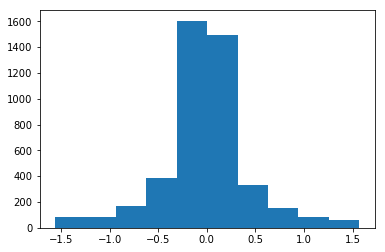

In [173]:
plt.hist(list(traj_orientations.values()))

In [ ]:
### Calculate Cell Sizes ###
cell_sizes = {}
for w in wells:
    w_fs = fs[w]
    
    paths = set(os.path.split(f)[0] for f in w_fs)
    paths = [os.path.join(path, 'cell_pixel_assignments.pkl') for path in paths]
    pixel_assigns = {path: pickle.load(open(path, 'rb')) for path in paths}

    for f in w_fs:
        path, cell_file = os.path.split(f)
        path = os.path.join(path, 'cell_pixel_assignments.pkl')
        t_point, cell_id = os.path.splitext(cell_file)[0].split('_')
        pixel_assign = pixel_assigns[path]
        
        cell_pixel_ps, cell_pixel_as = pixel_assign[int(t_point)]
        size = np.where(cell_pixel_as == int(cell_id))[0].shape[0]
        cell_sizes[f] = size
with open(os.path.join(raw_folder, 'all_patches_cell_sizes.pkl'), 'wb') as f:
    pickle.dump(cell_sizes, f)

### Calculate Cell Peak Intensities. Aspect Ratios ###
cell_intensities = {}
cell_aprs = {}
cell_aprs_nr = {}
for site in sites_NOVEMBER:
    print(site)
    well = site[:2]
    paths = [os.path.join(supp_folder, '%s-supps' % well, '%s' % site, 'stacks_%d.pkl' % i) for i in range(159)]
    for path in paths:
        p_dat = pickle.load(open(path, 'rb'))
        for k, v in p_dat.items():
            mat = v['masked_mat']
            cell_intensities[k] = get_density(mat)
            cell_aprs[k] = get_angle_apr(mat)
            cell_aprs_nr[k] = get_aspect_ratio_no_rotation(mat)
    with open(os.path.join(raw_folder, 'all_patches_cell_intensities.pkl'), 'wb') as f:
        pickle.dump(cell_intensities, f)
    with open(os.path.join(raw_folder, 'all_patches_cell_aspect_ratios.pkl'), 'wb') as f:
        pickle.dump(cell_aprs, f)
    with open(os.path.join(raw_folder, 'all_patches_cell_aspect_ratios_nr.pkl'), 'wb') as f:
        pickle.dump(cell_aprs_nr, f)

In [ ]:
### Calculate Cell Envs ###
cell_envs = {}
for w in wells:
    w_fs = fs[w]    
    
    paths = set(os.path.split(f)[0] for f in w_fs)
    paths = [os.path.join(path, 'cell_positions.pkl') for path in paths]
    cell_nbs = {}
    for path in paths:
        cell_positions = pickle.load(open(path, 'rb'))
        cell_nb = {}
        for t_point in cell_positions:
            poses = dict(sum(cell_positions[t_point], []))
            inds = sorted(poses.keys())
            positions = np.array([poses[i] for i in inds])
            dist_mat = np.linalg.norm(positions.reshape((-1, 1, 2)) - positions.reshape((1, -1, 2)), ord=2, axis=2)
            cell_nb[t_point] = (inds, dist_mat)
        cell_nbs[path] = cell_nb

    for f in w_fs:
        path, cell_file = os.path.split(f)
        path = os.path.join(path, 'cell_positions.pkl')
        t_point, cell_id = os.path.splitext(cell_file)[0].split('_')
        inds, dist_mat = cell_nbs[path][int(t_point)]
        neighbors = dist_mat[inds.index(int(cell_id))]
        cell_envs[f] = neighbors


In [ ]:
### Samples along each PC axis ###
slices = []
for pc_i in range(4):
    PCs = all_dats[:, pc_i]
    for i in range(5):
        low_thr = np.percentile(PCs, i * 20)
        up_thr = np.percentile(PCs, (i+1)* 20)
        inds = np.where((PCs > low_thr) & (PCs < up_thr))[0]
        inds = np.random.choice(inds, (1000,), replace=False)
        fs_selected = [all_fs[i] for i in inds]
        samples = [all_patches[f].data.numpy()[0, 0] for f in fs_selected]
        avg_slice = np.stack(samples, 0).mean(0)
        plt.subplot(5, 5, i+1)
        plt.imshow(avg_slice, vmin=0.49, vmax=0.75)
        plt.axis('off')
    plt.savefig('NOVEMBER_PC%d_trend.png' % (pc_i+1), dpi=1200)

In [ ]:
### Sample input/output ###
model = VQ_VAE(alpha=0.0005, gpu=True)
model = model.cuda()
model.load_state_dict(torch.load('HiddenStateExtractor/save_0005_bkp4.pt'))

sample_fs = ['/gpfs/CompMicro/Projects/learningCellState/microglia/raw_for_segmentation/NOVEMBER/supp/B4-supps/B4-Site_2/9_50.h5',
             '/gpfs/CompMicro/Projects/learningCellState/microglia/raw_for_segmentation/NOVEMBER/supp/C5-supps/C5-Site_2/23_79.h5',
             '/gpfs/CompMicro/Projects/learningCellState/microglia/raw_for_segmentation/NOVEMBER/supp/C5-supps/C5-Site_3/10_34.h5']
for i, f in enumerate(sample_fs):
    sample = all_patches[f]
    output = model(sample.cuda())[0]
    inp = sample.cpu().data.numpy()
    out = output.cpu().data.numpy()
    input_phase = (inp[0, 0] * 65535).astype('uint16')
    output_phase = (out[0, 0] * 65535).astype('uint16')
    input_retardance = (inp[0, 1] * 65535).astype('uint16')
    output_retardance = (out[0, 1] * 65535).astype('uint16')
    cv2.imwrite('NOVEMBER_samples_%d_input_phase.png' % i, enhance_contrast(input_phase, 1., -10000)) # Note dataset has been rescaled
    cv2.imwrite('NOVEMBER_samples_%d_output_phase.png' % i, enhance_contrast(output_phase, 1., -10000))
    cv2.imwrite('NOVEMBER_samples_%d_input_retardance.png' % i, enhance_contrast(input_retardance, 2., 0.))
    cv2.imwrite('NOVEMBER_samples_%d_output_retardance.png' % i, enhance_contrast(output_retardance, 2., 0.))

In [ ]:
### PCA plot for fig 3 ###
sizes = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_sizes.pkl'), 'rb'))

df = {'PC1': np.concatenate([patch_PC1[w] for w in wells_]),
      'PC2': np.concatenate([patch_PC2[w] for w in wells_]),
      'sizes': np.concatenate([[sizes[f] for f in fs[w]] for w in wells_])}

cmap = matplotlib.cm.get_cmap('BuPu')  
range_min = np.log(min(df['sizes']))
range_max = np.log(max(df['sizes']))
cs = [cmap(((np.log(s) - range_min)/(range_max - range_min))**1.5) for s in df['sizes']]

plt.clf()
sns.set_style('white')
fig, ax = plt.subplots()

random_subset_inds = np.random.choice(np.arange(len(df['PC1'])), (80000,), replace=False)

ax.scatter(df['PC1'][random_subset_inds], 
           df['PC2'][random_subset_inds], 
           c=[cs[i] for i in random_subset_inds], 
           s=1., 
           edgecolors='none')
plt.xlabel("")
plt.ylabel("")


traj_samples = ['B2-Site_0/35',
                'C4-Site_2/189',
                'B2-Site_5/21',
                'C4-Site_2/3']
selected_frames = [np.array([0, 60, 90, 120, 150]),
                   np.array([0, 30, 45, 60, 74]),
                   np.array([0, 60, 90, 120, 150]),
                   np.array([0, 60, 80, 120, 140])]
cmap2 = matplotlib.cm.get_cmap('tab10')
colors2 = [cmap2.colors[1],
           cmap2.colors[5], 
           (0.15, 0.5, 0.15), 
           (0.2, 0.2, 0.2)]
for ct, (t, inds, c) in enumerate(zip(traj_samples, selected_frames, colors2)):
    well = t[:2]
    order = np.array(traj_inds[t])
    ax.plot(dats[well][order][:, 0], dats[well][order][:, 1], '.--', c=c, linewidth=0.5, markersize=0.5)
    ax.plot(dats[well][order][inds][:, 0], dats[well][order][inds][:, 1], '.', c=c, markersize=2.0)
    for i in range(len(inds) - 1):
        ind0 = inds[i]
        ind1 = inds[i+1]
        ax.arrow(dats[well][order[ind0], 0],
                 dats[well][order[ind0], 1],
                 dats[well][order[ind1], 0] - dats[well][order[ind0], 0],
                 dats[well][order[ind1], 1] - dats[well][order[ind0], 1],
                 fc='none',
                 ec=c,
                 length_includes_head=True,
                 head_width=0.2, 
                 head_length=0.3)
    names = []
    output_paths = []
    for j, ind in enumerate(order[inds]):
        f = fs[well][ind]
        site = f.split('/')[-2]
        well = site[:2]
        t_point = int(f.split('/')[-1].split('_')[0])
        
        path = os.path.join(supp_folder, '%s-supps' % well, site, 'stacks_%d.pkl' % t_point)
        sample_dat = pickle.load(open(path, 'rb'))[f]['mat']
        cv2.imwrite('NOVEMBER_traj_sample_%d_%d.png' % (ct, j), 
                    enhance_contrast(sample_dat[:, :, 0], phase_a, phase_b).astype('uint16'))

plt.tight_layout()
plt.savefig("NOVEMBER_PCA.eps")

In [ ]:
# ts_of_I = []
# for t in trajs:
#     well = t[:2]
#     t_pc = np.array([dats[well][ind, :2] for ind in traj_inds[t]])
#     t_neighbors = [sorted(cell_envs[fs[well][ind]])[1] for ind in traj_inds[t]]
#     if np.percentile(t_neighbors, 5) < 70:
#         continue
#     if len(t_pc) > 30:
#         i = 0
#         centers = {}
#         while (i+10) < len(t_pc):
#             center = t_pc[i:(i+10)].mean(0)
#             std = t_pc[i:(i+10)].std(0)
#             if std.sum() < 2:
#                 centers[i] = center
#                 i += 12
#             else:
#                 i += 1
#         if len(centers) > 1:
#             centers = np.array(list(centers.values()))
#             if np.max(np.linalg.norm(centers.reshape((-1, 1, 2)) - centers.reshape((1, -1, 2)), ord=2, axis=2)) > 4:
#                 ts_of_I.append(t)

ts_of_I = [
    'B2-Site_0/11',
    'B2-Site_0/35',
    'B2-Site_0/40',
    'B2-Site_0/45',
    'B2-Site_0/48',
    'B2-Site_0/221',
    'B2-Site_1/74',
    'B2-Site_2/9',
    'B2-Site_5/35',
    'B2-Site_5/125',
    'B4-Site_0/67',
    'B4-Site_6/65',
    'B5-Site_7/3',
    'C4-Site_0/49',
    'C4-Site_0/77',
    'C4-Site_2/51',
    'C4-Site_2/52',
    'C4-Site_2/53',
    'C4-Site_2/59',
    'C4-Site_2/149',
    'C4-Site_2/189',
    'C4-Site_3/109',
    'C5-Site_3/22'
]

# for t in ts_of_I:
#     plt.clf()
#     well = t[:2]
#     t_pc = np.array([dats[well][ind, :2] for ind in traj_inds[t]])
#     plt.plot(t_pc[:, 0], t_pc[:, 1], '.-')
#     plt.xlim(-7, 11)
#     plt.ylim(-4, 12)
#     plt.savefig('traj_selected/%s.png' % t.replace('/', '_'))
#    save_traj_bbox(t, 'traj_selected/%s_box.gif' % t.replace('/', '_'))

In [ ]:
### PC1, PC2, speed individual distribution ###
# Patch level
sns.set_style("whitegrid")
plt.clf()
f = plt.figure(figsize=(4.5, 3))
for well in wells_:
    freqs, bins = np.histogram(patch_PC1[well], bins=bins_PC1, normed=True)
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, c=colors[well], label=legends[well])
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()
plt.savefig("NOVEMBER_all_patch_PC1.png", dpi=300)
plt.savefig("NOVEMBER_all_patch_PC1.eps")

plt.clf()
f = plt.figure(figsize=(4.5, 3))
for well in wells_:
    freqs, bins = np.histogram(patch_PC2[well], bins=bins_PC2, normed=True)
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, c=colors[well], label=legends[well])
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()
plt.savefig("NOVEMBER_all_patch_PC2.png", dpi=300)
plt.savefig("NOVEMBER_all_patch_PC2.eps")


# Trajectory level
plt.clf()
f = plt.figure(figsize=(4.5, 3))
for well in wells_:
    freqs, bins = np.histogram(traj_PC1[well], bins=bins_PC1, normed=True)
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, c=colors[well], label=legends[well])
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()
plt.savefig("NOVEMBER_all_traj_PC1.png", dpi=300)
plt.savefig("NOVEMBER_all_traj_PC1.eps")

plt.clf()
f = plt.figure(figsize=(4.5, 3))
for well in wells_:
    freqs, bins = np.histogram(traj_PC2[well], bins=bins_PC2, normed=True)
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, c=colors[well], label=legends[well])
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()
plt.savefig("NOVEMBER_all_traj_PC2.png", dpi=300)
plt.savefig("NOVEMBER_all_traj_PC2.eps")

plt.clf()
f = plt.figure(figsize=(4.5, 3))
for well in wells_:
    freqs, bins = np.histogram(traj_speed[well], bins=bins_speed, normed=True)
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, c=colors[well], label=legends[well])
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(b=False, which='major', axis='x')
speed_ticks = [4., 8., 16., 32., 64., 128.]
plt.gca().set_xticks(np.log(speed_ticks))
plt.gca().set_xticklabels(speed_ticks)
plt.tight_layout()
plt.savefig("NOVEMBER_all_traj_speed.png", dpi=300)
plt.savefig("NOVEMBER_all_traj_speed.eps")



In [ ]:
### PC1-PC2, PC1-speed, PC2-speed density plot ###


# plot_fn = plot_joint_density
plot_fn = plot_joint_kde
sns.set_style("white")

# Patch level
# for well in wells:
#     df = {'PC1': patch_PC1[well], 'PC2': patch_PC2[well]}
#     plt.clf()
#     plot_fn('PC1', 'PC2', df, bins_PC1, bins_PC2, cmap=cmaps[well])
#     plt.xlabel("")
#     plt.ylabel("")
#     plt.text(bins_PC1[2], bins_PC2[-3], legends[well], fontdict={"size": 16})
#     plt.tight_layout()
#     plt.savefig("NOVEMBER_%s_patch_PC1_PC2.png" % well, dpi=300)
#     plt.savefig("NOVEMBER_%s_patch_PC1_PC2.eps" % well)

# df = {'PC1': np.concatenate([patch_PC1[w] for w in wells]),
#       'PC2': np.concatenate([patch_PC2[w] for w in wells])}
# plt.clf()
# plot_fn('PC1', 'PC2', df, bins_PC1, bins_PC2, cmap=cmaps['all'])
# plt.xlabel("")
# plt.ylabel("")
# plt.text(bins_PC1[2], bins_PC2[-3], 'All', fontdict={"size": 16})
# plt.tight_layout()
# plt.savefig("NOVEMBER_all_patch_PC1_PC2.png", dpi=300)
# plt.savefig("NOVEMBER_all_patch_PC1_PC2.eps")


# Trajectory level
for well in wells_:
    df = {'PC1': traj_PC1[well], 'PC2': traj_PC2[well], 'Speed': traj_speed[well]}
    speed_ticks = [4, 16, 64]
#     plt.clf()
#     plot_fn('PC1', 'PC2', df, bins_PC1, bins_PC2, cmap=cmaps[well])
#     plt.xlabel("")
#     plt.ylabel("")
#     plt.text(bins_PC1[2], bins_PC2[-3], legends[well], fontdict={"size": 16})
#     plt.tight_layout()
#     plt.savefig("NOVEMBER_%s_trajectory_PC1_PC2.png" % well, dpi=300)
#     plt.savefig("NOVEMBER_%s_trajectory_PC1_PC2.eps" % well)
    
    plt.clf()
    f = plt.figure(figsize=(2.5, 2.5))
    sns.kdeplot(df['PC1'], df['Speed'], cmap=cmaps[well], shade=True)
    plt.xlabel("")
    plt.ylabel("")
    plt.xlim(bins_PC1[0], bins_PC1[-1])
    plt.ylim(bins_speed[0], bins_speed[-1])
    plt.gca().set_yticks(np.log(speed_ticks))
    plt.gca().set_yticklabels(speed_ticks)
    plt.text(bins_PC1[1], bins_speed[1], legends[well], fontdict={"size": 16})
    plt.tight_layout()
    plt.savefig("NOVEMBER_%s_trajectory_PC1_speed.png" % well, dpi=300)
    plt.savefig("NOVEMBER_%s_trajectory_PC1_speed.eps" % well)

    plt.clf()
    f = plt.figure(figsize=(2.5, 2.5))
    sns.kdeplot(df['PC2'], df['Speed'], cmap=cmaps[well], shade=True)
    plt.xlabel("")
    plt.ylabel("")
    plt.xlim(bins_PC2[0], bins_PC2[-1])
    plt.ylim(bins_speed[0], bins_speed[-1])
    plt.gca().set_yticks(np.log(speed_ticks))
    plt.gca().set_yticklabels(speed_ticks)
    plt.text(bins_PC2[1], bins_speed[1], legends[well], fontdict={"size": 16})
    plt.tight_layout()
    plt.savefig("NOVEMBER_%s_trajectory_PC2_speed.png" % well, dpi=300)
    plt.savefig("NOVEMBER_%s_trajectory_PC2_speed.eps" % well)

speed_ticks = [4, 8, 16, 32, 64, 128]
df = {'PC1': np.concatenate([traj_PC1[w] for w in wells_]),
      'PC2': np.concatenate([traj_PC2[w] for w in wells_]),
      'Speed': np.concatenate([traj_speed[w] for w in wells_])}

# plt.clf()
# plot_fn('PC1', 'PC2', df, bins_PC1, bins_PC2, cmap=cmaps['all'])
# plt.xlabel("")
# plt.ylabel("")
# plt.text(bins_PC1[2], bins_PC2[-3], 'All', fontdict={"size": 16})
# plt.tight_layout()
# plt.savefig("NOVEMBER_all_trajectory_PC1_PC2.png", dpi=300)
# plt.savefig("NOVEMBER_all_trajectory_PC1_PC2.eps")

plt.clf()
f = plt.figure(figsize=(3, 3))
sns.kdeplot(df['PC1'], df['Speed'], cmap=ListedColormap(generate_color_vectors('#ffffff', '#888888')), shade=True)
plt.xlabel("")
plt.ylabel("")
plt.xlim(bins_PC1[0], bins_PC1[-1])
plt.ylim(bins_speed[0], bins_speed[-1])
plt.gca().set_yticks(np.log(speed_ticks))
plt.gca().set_yticklabels(speed_ticks)
plt.text(bins_PC1[1], bins_speed[1], 'All', fontdict={"size": 20})
plt.tight_layout()
plt.savefig("NOVEMBER_all_trajectory_PC1_speed.png", dpi=300)
plt.savefig("NOVEMBER_all_trajectory_PC1_speed.eps")

plt.clf()
f = plt.figure(figsize=(3, 3))
sns.kdeplot(df['PC2'], df['Speed'], cmap=ListedColormap(generate_color_vectors('#ffffff', '#888888')), shade=True)
plt.xlabel("")
plt.ylabel("")
plt.xlim(bins_PC2[0], bins_PC2[-1])
plt.ylim(bins_speed[0], bins_speed[-1])
plt.gca().set_yticks(np.log(speed_ticks))
plt.gca().set_yticklabels(speed_ticks)
plt.text(bins_PC2[1], bins_speed[1], 'All', fontdict={"size": 20})
plt.tight_layout()
plt.savefig("NOVEMBER_all_trajectory_PC2_speed.png", dpi=300)
plt.savefig("NOVEMBER_all_trajectory_PC2_speed.eps")

In [ ]:
### Representative Trajectories ###
t_lag = 1
def extract_representatives(traj_pool, target_PC1=(None, None), target_PC2=(None, None), target_dist=(None, None)):
    selected_ts = []
    properties = {}
    for t in traj_pool:
        well = t[:2]
        t_keys = sorted(trajs[t].keys())
        dists = []
        for t_point in t_keys:
            if (t_point + t_lag) in t_keys:
                d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                                   traj_positions[t][t_point], ord=2)
                dists.append(d)
        traj_pc1 = [dats[well][ind, 0] for ind in traj_inds[t]]
        traj_pc2 = [dats[well][ind, 1] for ind in traj_inds[t]]
        traj_dist = np.array(dists) * 0.72222
        if not target_PC1[0] is None:
            if np.mean(traj_pc1) < target_PC1[0]:
                continue
        if not target_PC1[1] is None:
            if np.mean(traj_pc1) > target_PC1[1]:
                continue
        if not target_PC2[0] is None:
            if np.mean(traj_pc2) < target_PC2[0]:
                continue
        if not target_PC2[1] is None:
            if np.mean(traj_pc2) > target_PC2[1]:
                continue
        if not target_dist[0] is None:
            if np.mean(traj_dist) < target_dist[0]:
                continue
        if not target_dist[1] is None:
            if np.mean(traj_dist) > target_dist[1]:
                continue
        selected_ts.append(t)
        properties[t] = (traj_pc1, traj_pc2, traj_dist)
    selected_ts = sorted(selected_ts, key=lambda x: np.std(properties[x][0]) + np.std(properties[x][1]))
    return selected_ts


In [ ]:
# Extract representative trajectories: B4
well = 'B4'
target_PC2 = [-1, 0]
target_dist = [8., 18.]
traj_pool = [t for t in trajs if t.startswith(well)]
selected_ts = extract_representatives(traj_pool, target_PC2=target_PC2, target_dist=target_dist)
#site_dat = torch.load(os.path.join(raw_folder, '%s_adjusted_static_patches.pt' % well))
for t in selected_ts[:20]:
    print("Writing %s" % t.replace('/', '_'))
    #save_movie(t, '%s_patch.gif' % t.replace('/', '_'))
    save_traj_bbox(t, '%s_box.gif' % t.replace('/', '_'))

In [ ]:
# Extract representative trajectories: B5
well = 'B5'
target_PC2 = [-1.5, -0.5]
target_dist = [4., 12.]
traj_pool = [t for t in trajs if t.startswith(well)]
selected_ts = extract_representatives(traj_pool, target_PC2=target_PC2, target_dist=target_dist)
#site_dat = torch.load(os.path.join(raw_folder, '%s_adjusted_static_patches.pt' % well))
for t in selected_ts[:20]:
    print("Writing %s" % t.replace('/', '_'))
    #save_movie(t, '%s_patch.gif' % t.replace('/', '_'))
    save_traj_bbox(t, '%s_box.gif' % t.replace('/', '_'))

In [ ]:
# Extract representative trajectories: B4
well = 'C4'
target_PC2 = [0, 1]
target_dist = [8., 18.]
traj_pool = [t for t in trajs if t.startswith(well)]
selected_ts = extract_representatives(traj_pool, target_PC2=target_PC2, target_dist=target_dist)
#site_dat = torch.load(os.path.join(raw_folder, '%s_adjusted_static_patches.pt' % well))
for t in selected_ts[:20]:
    print("Writing %s" % t.replace('/', '_'))
    #save_movie(t, '%s_patch.gif' % t.replace('/', '_'))
    save_traj_bbox(t, '%s_box.gif' % t.replace('/', '_'))

In [ ]:
# Extract representative trajectories: C5
well = 'C5'
target_PC2 = [2.5, 3.5]
target_dist = [18., 36.]
traj_pool = [t for t in trajs if t.startswith(well)]
selected_ts = extract_representatives(traj_pool, target_PC2=target_PC2, target_dist=target_dist)
#site_dat = torch.load(os.path.join(raw_folder, '%s_adjusted_static_patches.pt' % well))
for t in selected_ts[:20]:
    print("Writing %s" % t.replace('/', '_'))
    #save_movie(t, '%s_patch.gif' % t.replace('/', '_'))
    save_traj_bbox(t, '%s_box.gif' % t.replace('/', '_'))

In [ ]:
# Extract representative trajectories: B2
well = 'B2'
target_PC2 = [3.5, 4.5]
target_dist = [12., 24.]
traj_pool = [t for t in trajs if t.startswith(well)]
selected_ts = extract_representatives(traj_pool, target_PC2=target_PC2, target_dist=target_dist)
#site_dat = torch.load(os.path.join(raw_folder, '%s_adjusted_static_patches.pt' % well))
for t in selected_ts[:20]:
    print("Writing %s" % t.replace('/', '_'))
    #save_movie(t, '%s_patch.gif' % t.replace('/', '_'))
    save_traj_bbox(t, 'mode_high_%s_box.gif' % t.replace('/', '_'))
    
target_PC2 = [0, 2]
target_dist = [4., 12.]
traj_pool = [t for t in trajs if t.startswith(well)]
selected_ts = extract_representatives(traj_pool, target_PC2=target_PC2, target_dist=target_dist)
#site_dat = torch.load(os.path.join(raw_folder, '%s_adjusted_static_patches.pt' % well))
for t in selected_ts[:20]:
    print("Writing %s" % t.replace('/', '_'))
    #save_movie(t, '%s_patch.gif' % t.replace('/', '_'))
    save_traj_bbox(t, 'mode_low_%s_box.gif' % t.replace('/', '_'))


In [170]:
### GMM to multiple states ###
t_lag = 1
traj_properties = {}
X = []
Y = []
t_arrays = []
for t in trajs:
    well = t[:2]
    if not well in wells_:
        continue
    t_keys = sorted(trajs[t].keys())
    dists = []
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            dists.append(d)
        
    traj_PC = [dats[well][ind] for ind in traj_inds[t]]
    traj_dist = dists
    traj_properties[t] = (traj_PC, traj_dist)
    X.append(np.concatenate([np.array(np.log(np.mean(traj_dist) * 0.325 / 0.1518)).reshape((-1,)), np.mean(traj_PC, 0)]))
    Y.append(sorted(wells_).index(well))
    t_arrays.append(t)
    
X = np.array(X)
Y = np.array(Y)
std_unit = np.std(X, 0)

In [171]:
### GMM ###
def calculate_sample_prob_mat(X, centers, stds):
    # Sample prob mat should be N * 2
    n_feat = X.shape[1]
    X_ = X.reshape((-1, 1, n_feat))
    centers_ = np.array(centers).reshape((1, -1, n_feat))
    stds_ = np.array(stds).reshape((1, -1, n_feat))
    prob_mat = np.square((X_ - centers_)/stds_).sum(2)
    prob_mat = prob_mat - prob_mat.min(1, keepdims=True)
    prob_mat = np.exp(-0.5 * prob_mat)
    return prob_mat


def initialize_well_prob_mat(sample_prob_mat, y):
    # Well prob mat should be 5*2
    classes = sorted(np.unique(y))
    prob_mat = np.zeros((len(classes), sample_prob_mat.shape[1]))
    for i, c in enumerate(classes):
        line = sample_prob_mat[np.where(y == c)].sum(0)
        line = line/line.sum()
        prob_mat[i] = line
    return prob_mat


def get_merged_prob_mat(X, y, centers, stds, well_prob_mat):
    # E-step
    sample_prob_mat = calculate_sample_prob_mat(X, centers, stds)
    prob_mat = []
    for i in range(len(X)):
        prob_ = sample_prob_mat[i] * well_prob_mat[y[i]]
        prob_ = prob_/prob_.sum()
        prob_mat.append(prob_)
    prob_mat = np.stack(prob_mat, 0)
    return prob_mat
    

def calculate_new_centers(X, y, prob_mat):
    # M-step
    classes = sorted(np.unique(y))
    weights = prob_mat

    outlying = np.zeros((X.shape[0],))
    for i, c in enumerate(classes):
        inds = np.where(y == c)
        X_c = X[inds]
        median_X_c = np.median(X_c, keepdims=True, axis=0)
        outlying[inds] = np.linalg.norm(X_c - median_X_c, axis=1, ord=2)  
  
    outlying = (1 - 0.7 * (outlying - outlying.min())/(outlying.max() - outlying.min())) ** 10.
    weights = weights * outlying.reshape((-1, 1))
  
    centers = []
    stds = []
    for i in range(weights.shape[1]):
        w = weights[:, i:(i+1)]
        center = (w * X).sum(0)/w.sum()
        centers.append(center)
        std = np.sqrt(((w * (X - center) ** 2).sum(0)/w.sum()))
        ratio = np.median((std/std_unit)[:5])
        stds.append(ratio * std_unit)

    well_prob_mat = []
    for i, c in enumerate(classes):
        inds = np.where(y == c)
        well_prob_mat.append(weights[inds].sum(0)/weights[inds].sum())
    well_prob_mat = np.stack(well_prob_mat, 0)
    return centers, stds, well_prob_mat
  
    
# Two states or three states
init_center1 = np.median(X[np.where(Y == 1)], 0)
init_center2 = np.median(X[np.where(Y == 3)], 0)
#init_center3 = np.median(X[np.where(Y == 0)], 0)
init_center1 += np.random.normal(0, 0.1, init_center1.shape)
init_center2 += np.random.normal(0, 0.1, init_center1.shape)
#init_center3 += np.random.normal(0, 0.1, init_center1.shape)
centers = [init_center1, init_center2]#, init_center3]
stds = [0.5*std_unit for c in centers]
well_prob_mat = initialize_well_prob_mat(calculate_sample_prob_mat(X, centers, stds), Y)

for i in range(10): 
    print(well_prob_mat)
    prob_mat = get_merged_prob_mat(X, Y, centers, stds, well_prob_mat)
    centers, _, well_prob_mat = calculate_new_centers(X, Y, prob_mat)
    stds = [0.5*std_unit for c in centers]


[[0.49878625 0.50121375]
 [0.764617   0.235383  ]
 [0.82571846 0.17428154]
 [0.40057747 0.59942253]]
[[0.51123316 0.48876684]
 [0.90329527 0.09670473]
 [0.94340335 0.05659665]
 [0.30329023 0.69670977]]
[[0.43980557 0.56019443]
 [0.9293946  0.0706054 ]
 [0.97248628 0.02751372]
 [0.24523972 0.75476028]]
[[0.41966079 0.58033921]
 [0.92562519 0.07437481]
 [0.97140623 0.02859377]
 [0.23235798 0.76764202]]
[[0.41267454 0.58732546]
 [0.92254935 0.07745065]
 [0.96968958 0.03031042]
 [0.22423803 0.77576197]]
[[0.40869004 0.59130996]
 [0.92070765 0.07929235]
 [0.96811731 0.03188269]
 [0.21917445 0.78082555]]
[[0.40609959 0.59390041]
 [0.91955204 0.08044796]
 [0.96697013 0.03302987]
 [0.21600197 0.78399803]]
[[0.4044002  0.5955998 ]
 [0.91880255 0.08119745]
 [0.96620536 0.03379464]
 [0.2139789  0.7860211 ]]
[[0.40329098 0.59670902]
 [0.91831082 0.08168918]
 [0.9657106  0.0342894 ]
 [0.2126761  0.7873239 ]]
[[0.40256988 0.59743012]
 [0.91798775 0.08201225]
 [0.96539278 0.03460722]
 [0.21183347 0.7

In [112]:
### Calculate trajectory states ###
state_cmaps = [plt.get_cmap(name) for name in ['Blues', 'Reds', 'Greens', 'Oranges']]
traj_states = {well: [] for well in wells_}
prob_mat = get_merged_prob_mat(X, Y, centers, stds, well_prob_mat)
for well in wells_:
    names = traj_names[well]
    for n in names:
        traj_states[well].append(prob_mat[t_arrays.index(n)])


B2
B4
B5
C5


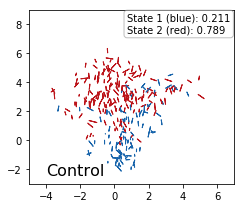

In [201]:
### Scatter (Arrow) plot of trajectory level PC1 - PC2 - speed ###

traj_vector_K2 = {}
K = 2
for t in trajs:
    well = t[:2]
    if not well in wells_:
        continue
    traj_full_dats = np.stack([dats[well][ind] for ind in traj_inds[t]], 0)
    segs = np.linspace(0, len(traj_inds[t]), K+1).astype(int)
    vs = []
    for i in range(len(segs) - 1):
        v = traj_full_dats[segs[i]:segs[i+1]].mean(0)
        vs.append(v)
    traj_vector_K2[t] = vs



# state_lengths = [[], []]
speed_ticks = [4., 8., 16., 32., 64., 128.]
for i_w, well in enumerate(sorted(wells_)):
    print(well)
    df = {'PC1': traj_PC1[well],
          'PC2': traj_PC2[well],
          'Speed': traj_speed[well],
          'State': traj_states[well],
          'Name': traj_names[well]}

    plt.clf()
    f = plt.figure(figsize=(3.5, 3))
    random_selected_inds = np.random.choice(np.arange(len(df['Name'])), (300,), replace=False)
    for i in random_selected_inds:
        t = df['Name'][i]
        if not t in traj_orientations:
            continue
        merged_ang_diff = traj_orientations[t]
        #merged_d = np.exp(df['Speed'][i])/200
        merged_d = (1 - traj_orientation_stds[t])/2 # Longer marker indicates more consistent movement (smaller circular SD)
        arrow_vec = (merged_d * np.sin(merged_ang_diff), merged_d * np.cos(merged_ang_diff))
        x_center = df['PC1'][i]
        y_center = df['PC2'][i]
        dx = arrow_vec[0]
        dy = arrow_vec[1]
        
#         x_center = np.mean([traj_vector_K2[t][i][0] for i in range(len(traj_vector_K2[t]))])
#         y_center = np.mean([traj_vector_K2[t][i][1] for i in range(len(traj_vector_K2[t]))])
#         dx = traj_vector_K2[t][-1][0] - traj_vector_K2[t][0][0]
#         dy = traj_vector_K2[t][-1][1] - traj_vector_K2[t][0][1]
#         dx = dx/4
#         dy = dy/4
        
        x = x_center - dx/2
        y = y_center - dy/2

        st = df['State'][i]
        if np.max(st) < 0.9:
            continue
        c = state_cmaps[np.argmax(st)](0.8)
        plt.arrow(x, y, dx, dy, color=c, width=0.005, head_width=0.)
#         plt.plot([x_center], [y_center], c=c, marker='*', markersize=5.)
#         state_lengths[np.argmax(st)].append(np.sqrt(dx**2 + dy**2))

    plt.xlabel("")
    plt.ylabel("")
    plt.xlim(-5, 7)
    plt.ylim(-3, 9)
    plt.text(bins_PC1[0], bins_PC2[1], legends[well], fontdict={"size": 16})
    bbox = dict(boxstyle='round', facecolor=(1., 1., 1., 0.5), edgecolor=(0.5, 0.5, 0.5, 0.5), alpha=0.5)
    plt.text(bins_PC1[-11], 
             bins_PC2[-2], 
             'State 1 (blue): %.3f\nState 2 (red): %.3f' % (well_prob_mat[i_w][0], well_prob_mat[i_w][1]), 
             fontdict={"size": 10},
             bbox=bbox)
    plt.tight_layout()
#     plt.show()
    plt.savefig("NOVEMBER_%s_traj_state_PC1_PC2_speed.png" % well, dpi=300)
    plt.savefig("NOVEMBER_%s_traj_state_PC1_PC2_speed.eps" % well)

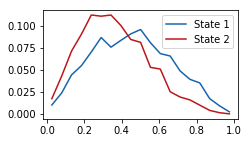

In [198]:
### Histogram of state orientations - patch level ###
orient_states = [[] for _ in range(2)]
displacement_states = [[] for _ in range(2)]
for i_w, well in enumerate(sorted(wells_)):
    df = {'PC1': traj_PC1[well],
          'PC2': traj_PC2[well],
          'Speed': traj_speed[well],
          'State': traj_states[well],
          'Name': traj_names[well]}
    for i in range(len(df['Name'])):
        t = df['Name'][i]
        if not t in traj_orientations:
            continue
        st = df['State'][i]
        traj_fs = [fs[well][ind] for ind in traj_inds[t]]
        orient_states[np.argmax(st)].extend([patch_orientations[f] for f in traj_fs if f in patch_orientations])
        displacement_states[np.argmax(st)].extend([patch_displacements[f] for f in traj_fs if f in patch_displacements])

plt.clf()
f = plt.figure(figsize=(3., 3.))
ax = plt.subplot(111, projection='polar')
bins = np.arange(-np.pi/2, np.pi/2 + np.pi/21, np.pi/21)
for i, sts in enumerate(orient_states):
    line, _ = np.histogram(sts, bins=bins)
    _x = (bins[:-1] + bins[1:])/2
    ax.plot(_x, line/sum(line), color=state_cmaps[i](0.8), label='State %d' % (i + 1))
ax.set_theta_zero_location('N')
ax.legend(fontsize=10, loc=(0.28, 0.08))
# plt.show()
plt.savefig("NOVEMBER_state_orient.png", dpi=300)
plt.savefig("NOVEMBER_state_orient.eps")

### Histogram of state displacements - patch level ###
plt.clf()
f = plt.figure(figsize=(3.5, 2))
bins = np.linspace(0., 6.0, 15)
for i, sts in enumerate(displacement_states):
    line, _ = np.histogram([np.log(s * 0.325 / 0.1518 + 1e-9) for s in sts], bins=bins)
    plt.plot((bins[:-1] + bins[1:])/2, line/sum(line), color=state_cmaps[i](0.8), label='State %d' % (i + 1))
speed_ticks = [1., 10., 100.]
speed_ticks_labels = ['10$^0$', '10$^1$', '10$^2$']
plt.gca().set_xticks(np.log(speed_ticks))
plt.gca().set_xticklabels(speed_ticks_labels)
plt.gca().set_yticks([0., 0.1, 0.2])
plt.legend(fontsize=10, loc=2)
# plt.show()
plt.savefig("NOVEMBER_state_displacement.png", dpi=300)
plt.savefig("NOVEMBER_state_displacement.eps")





### Histogram of state orientations - traj level ###
orient_states = [[] for _ in range(2)]
orient_stds_states = [[] for _ in range(2)]
displacement_states = [[] for _ in range(2)]
for i_w, well in enumerate(sorted(wells_)):
    df = {'PC1': traj_PC1[well],
          'PC2': traj_PC2[well],
          'Speed': traj_speed[well],
          'State': traj_states[well],
          'Name': traj_names[well]}
    for i in range(len(df['Name'])):
        t = df['Name'][i]
        if not t in traj_orientations:
            continue
        st = df['State'][i]
        # merged_ang_diff = traj_orientations[t]
        # orient_states[np.argmax(st)].append(merged_ang_diff)
        traj_fs = [fs[well][ind] for ind in traj_inds[t]]
        orient_states[np.argmax(st)].append(traj_orientations[t])
        orient_stds_states[np.argmax(st)].append(traj_orientation_stds[t])
        displacement_states[np.argmax(st)].append(np.mean([patch_displacements[f] for f in traj_fs if f in patch_displacements]))

plt.clf()
f = plt.figure(figsize=(3., 3.))
ax = plt.subplot(111, projection='polar')
bins = np.arange(-np.pi/2, np.pi/2 + np.pi/21, np.pi/21)
for i, sts in enumerate(orient_states):
    line, _ = np.histogram(sts, bins=bins)
    _x = (bins[:-1] + bins[1:])/2
    ax.plot(_x, line/line.sum(), color=state_cmaps[i](0.8), label='State %d' % (i + 1))
ax.set_theta_zero_location('N')
ax.legend(fontsize=10, loc=(0.28, 0.08))
# plt.show()
plt.savefig("NOVEMBER_traj_state_orient.png", dpi=300)
plt.savefig("NOVEMBER_traj_state_orient.eps")

### Histogram of state displacements - traj level ###
plt.clf()
f = plt.figure(figsize=(3.5, 2))
bins = np.linspace(0., 6.0, 15)
for i, sts in enumerate(displacement_states):
    line, _ = np.histogram([np.log(s * 0.325 / 0.1518 + 1e-9) for s in sts], bins=bins)
    plt.plot((bins[:-1] + bins[1:])/2, line/len(sts), color=state_cmaps[i](0.8), label='State %d' % (i + 1))
speed_ticks = [1., 10., 100.]
speed_ticks_labels = ['10$^0$', '10$^1$', '10$^2$']
plt.gca().set_xticks(np.log(speed_ticks))
plt.gca().set_xticklabels(speed_ticks_labels)
plt.gca().set_yticks([0., 0.1, 0.2])
plt.legend(fontsize=10, loc=2)
# plt.show()
plt.savefig("NOVEMBER_traj_state_displacement.png", dpi=300)
plt.savefig("NOVEMBER_traj_state_displacement.eps")

### Histogram of state orientation stds - traj level ###
plt.clf()
f = plt.figure(figsize=(3.5, 2))
bins = np.linspace(0., 1.0, 20)
for i, sts in enumerate(orient_stds_states):
    line, _ = np.histogram(sts, bins=bins)
    plt.plot((bins[:-1] + bins[1:])/2, line/len(sts), color=state_cmaps[i](0.8), label='State %d' % (i + 1))
plt.legend(fontsize=10)
# plt.show()
plt.savefig("NOVEMBER_traj_state_orient_std.png", dpi=300)
plt.savefig("NOVEMBER_traj_state_orient_std.eps")


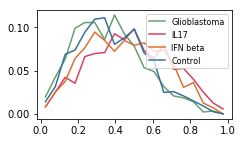

In [206]:
### Histogram of well orientations - patch level ###
plt.clf()
f = plt.figure(figsize=(3., 3.))
ax = plt.subplot(111, projection='polar')
bins = np.arange(-np.pi/2, np.pi/2 + np.pi/21, np.pi/21)
for i_w, well in enumerate(sorted(wells_)):
    df = {'PC1': traj_PC1[well],
          'PC2': traj_PC2[well],
          'Speed': traj_speed[well],
          'State': traj_states[well],
          'Name': traj_names[well]}
    orient_state = []
    for i in range(len(df['Name'])):
        t = df['Name'][i]
        if not t in traj_orientations:
            continue
        traj_fs = [fs[well][ind] for ind in traj_inds[t]]
        orient_state.extend([patch_orientations[f] for f in traj_fs if f in patch_orientations])
    line, _ = np.histogram(orient_state, bins=bins)
    _x = (bins[:-1] + bins[1:])/2
    ax.plot(_x, line/sum(line), color=cmaps[well](0.8), label=legends[well])
ax.set_theta_zero_location('N')
ax.legend(fontsize=8, loc=(0., 0.))
plt.savefig("NOVEMBER_well_orient.png", dpi=300)
plt.savefig("NOVEMBER_well_orient.eps")

### Histogram of well displacement - patch level ###
plt.clf()
f = plt.figure(figsize=(3.5, 2))
bins = np.linspace(0., 6.0, 15)
for i_w, well in enumerate(sorted(wells_)):
    df = {'PC1': traj_PC1[well],
          'PC2': traj_PC2[well],
          'Speed': traj_speed[well],
          'State': traj_states[well],
          'Name': traj_names[well]}
    displacement_state = []
    for i in range(len(df['Name'])):
        t = df['Name'][i]
        if not t in traj_orientations:
            continue
        traj_fs = [fs[well][ind] for ind in traj_inds[t]]
        displacement_state.extend([patch_displacements[f] for f in traj_fs if f in patch_displacements])
    line, _ = np.histogram([np.log(s * 0.325 / 0.1518 + 1e-9) for s in displacement_state], bins=bins)
    _x = (bins[:-1] + bins[1:])/2
    plt.plot(_x, line/len(displacement_state), color=cmaps[well](0.8), label=legends[well])
    
speed_ticks = [1., 10., 100.]
speed_ticks_labels = ['10$^0$', '10$^1$', '10$^2$']
plt.gca().set_xticks(np.log(speed_ticks))
plt.gca().set_xticklabels(speed_ticks_labels)
plt.gca().set_yticks([0., 0.1, 0.2])
plt.legend(fontsize=8)
plt.savefig("NOVEMBER_well_displacement.png", dpi=300)
plt.savefig("NOVEMBER_well_displacement.eps")



### Histogram of well orientations - traj level ###
plt.clf()
f = plt.figure(figsize=(3., 3.))
ax = plt.subplot(111, projection='polar')
bins = np.arange(-np.pi/2, np.pi/2 + np.pi/21, np.pi/21)
for i_w, well in enumerate(sorted(wells_)):
    df = {'PC1': traj_PC1[well],
          'PC2': traj_PC2[well],
          'Speed': traj_speed[well],
          'State': traj_states[well],
          'Name': traj_names[well]}
    orient_state = []
    for i in range(len(df['Name'])):
        t = df['Name'][i]
        if not t in traj_orientations:
            continue
        orient_state.append(traj_orientations[t])
    line, _ = np.histogram(orient_state, bins=bins)
    _x = (bins[:-1] + bins[1:])/2
    ax.plot(_x, line/sum(line), color=cmaps[well](0.8), label=legends[well])
ax.set_theta_zero_location('N')
ax.legend(fontsize=8, loc=(0., 0.))
plt.savefig("NOVEMBER_traj_well_orient.png", dpi=300)
plt.savefig("NOVEMBER_traj_well_orient.eps")

### Histogram of well displacements - traj level ###
plt.clf()
f = plt.figure(figsize=(3.5, 2))
bins = np.linspace(0., 6.0, 15)
for i_w, well in enumerate(sorted(wells_)):
    df = {'PC1': traj_PC1[well],
          'PC2': traj_PC2[well],
          'Speed': traj_speed[well],
          'State': traj_states[well],
          'Name': traj_names[well]}
    displacement_state = []
    for i in range(len(df['Name'])):
        t = df['Name'][i]
        if not t in traj_orientations:
            continue
        traj_fs = [fs[well][ind] for ind in traj_inds[t]]
        displacement_state.append(np.mean([patch_displacements[f] for f in traj_fs if f in patch_displacements]))
    line, _ = np.histogram([np.log(s * 0.325 / 0.1518 + 1e-9) for s in displacement_state], bins=bins)
    _x = (bins[:-1] + bins[1:])/2
    plt.plot(_x, line/len(displacement_state), color=cmaps[well](0.8), label=legends[well])
speed_ticks = [1., 10., 100.]
speed_ticks_labels = ['10$^0$', '10$^1$', '10$^2$']
plt.gca().set_xticks(np.log(speed_ticks))
plt.gca().set_xticklabels(speed_ticks_labels)
plt.gca().set_yticks([0., 0.1, 0.2])
plt.legend(fontsize=8)
plt.savefig("NOVEMBER_traj_well_displacement.png", dpi=300)
plt.savefig("NOVEMBER_traj_well_displacement.eps")

### Histogram of well orientation stds - traj level ###
plt.clf()
f = plt.figure(figsize=(3.5, 2))
bins = np.linspace(0., 1.0, 20)

for i_w, well in enumerate(sorted(wells_)):
    df = {'PC1': traj_PC1[well],
          'PC2': traj_PC2[well],
          'Speed': traj_speed[well],
          'State': traj_states[well],
          'Name': traj_names[well]}
    orient_std_state = []
    for i in range(len(df['Name'])):
        t = df['Name'][i]
        if not t in traj_orientations:
            continue
        orient_std_state.append(traj_orientation_stds[t])
    line, _ = np.histogram(orient_std_state, bins=bins)
    _x = (bins[:-1] + bins[1:])/2
    plt.plot(_x, line/len(orient_std_state), color=cmaps[well](0.8), label=legends[well])
plt.legend(fontsize=8)
plt.savefig("NOVEMBER_traj_well_orient_std.png", dpi=300)
plt.savefig("NOVEMBER_traj_well_orient_std.eps")

In [113]:
### Collect samples for each state centers ###
center_samples = []
prob_mat = get_merged_prob_mat(X, Y, centers, stds, well_prob_mat)
for i_c, c in enumerate(centers):
    print(i_c)
    samples = []
    inds = np.where(prob_mat[:, i_c] > 0.8)[0]
    for i in inds:
        if (np.abs(X[i] - c)/std_unit)[:3].mean() < 0.5:
            samples.append(t_arrays[i])
    samples = sorted(samples, key=lambda x: (np.array(traj_properties[x][0]).std(0)[:2]).sum())
    center_samples.append(samples)

0
1


In [ ]:
### Sample trajectories with traj marked ###
np.random.seed(130)
traj_represented = [
    'B5-Site_2/16',
    'C4-Site_5/143',
    'C4-Site_3/23',
    'C5-Site_1/98',
    'C5-Site_2/307',
    'C5-Site_1/299'
]
cs = [(171, 100, 23)] * 3 + [(26, 20, 188)] * 3

for t, c in zip(traj_represented, cs):
    well = t[:2]
    traj = traj_inds[t]
    
    site = t.split('/')[0]
    image_stack = np.load(os.path.join(raw_folder, '%s.npy' % site))
    
    t_pos = traj_positions[t]
    init_t_point = sorted(t_pos.keys())[0]
    init_position = t_pos[init_t_point]
    if init_position[0] < 256 or init_position[0] > (2048-256) or init_position[1] < 256 or init_position[1] > (2048-256):
        continue

    f0 = image_stack[init_t_point, 
                     (init_position[0]-256):(init_position[0]+256),
                     (init_position[1]-256):(init_position[1]+256),
                     0]
    
    f0 = enhance_contrast(f0, phase_a, phase_b)
    mat = np.zeros((f0.shape[0], f0.shape[1], 3), dtype='uint8')
    mat[:, :] = (np.expand_dims(f0, 2) / 256).astype('uint8')
    try:
        t_pos = traj_positions[t]
        positions = np.stack([t_pos[k] for k in sorted(t_pos.keys())])
        center_position = positions[0] - np.array([256, 256])
        for i in range(positions.shape[0] - 1):
            start = positions[i] - center_position
            end = positions[i + 1] - center_position
            mat = cv2.line(mat, (start[1], start[0]), (end[1], end[0]), c, thickness=2)
        cv2.imwrite('NOVEMBER_center_sample_%s.png' % t.replace('/', '_'), mat)
    except Exception as e:
        print(e)


In [114]:
### Calcualte Trajectory MSDs ###
MSD_length = 30

# MSD by states
center_cut_ensembles = []
for i_c, c in enumerate(centers):
    target_trajs = center_samples[i_c]
    cut_ensemble = []
    for t in target_trajs:
        t_end = max(traj_positions[t].keys()) + 1
        for t_start in range(t_end - MSD_length):
            if t_start in traj_positions[t]:
                s_traj = {(t_now - t_start): traj_positions[t][t_now] \
                    for t_now in range(t_start, t_start+MSD_length) if t_now in traj_positions[t]}
                cut_ensemble.append(s_traj)
    center_cut_ensembles.append(cut_ensemble)

center_MSDs = [{i: [] for i in range(MSD_length)} for _ in range(len(centers))]
for i_c, cut_ensemble in enumerate(center_cut_ensembles):
    for cut in cut_ensemble:
        for i in range(MSD_length):
            if i in cut:
                center_MSDs[i_c][i].append(np.square(cut[i] - cut[0]).sum() * 0.325**2) # unit of um^2

# MSD all and MSD by well
all_cut_ensembles = []
well_cut_ensembles = {w: [] for w in wells_}
for t in trajs:
    well = t[:2]
    if not well in wells_:
        continue
    t_end = max(traj_positions[t].keys()) + 1
    for t_start in range(t_end - MSD_length):
        if t_start in traj_positions[t]:
            s_traj = {(t_now - t_start): traj_positions[t][t_now] \
                for t_now in range(t_start, t_start+MSD_length) if t_now in traj_positions[t]}
            all_cut_ensembles.append(s_traj)
            well_cut_ensembles[well].append(s_traj)

all_MSDs = {i: [] for i in range(MSD_length)}
for cut in all_cut_ensembles:
    for i in range(MSD_length):
        if i in cut:
            all_MSDs[i].append(np.square(cut[i] - cut[0]).sum() * 0.325**2) # unit of um^2


well_MSDs = {w: {i: [] for i in range(MSD_length)} for w in wells_}
for w, cut_ensemble in well_cut_ensembles.items():
    for cut in cut_ensemble:
        for i in range(MSD_length):
            if i in cut:
                well_MSDs[w][i].append(np.square(cut[i] - cut[0]).sum() * 0.325**2) # unit of um^2


State 1: 5.207430 * t ^ (0.878902)
0.9966381009493156
State 2: 6.357683 * t ^ (0.910582)
0.9983570813431863


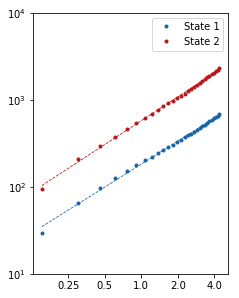

In [115]:
### Plot MSD ###
from matplotlib.ticker import NullLocator
import sklearn
from sklearn.linear_model import LinearRegression

x = np.log(np.arange(1, MSD_length) * 0.1518) # log of hour
    

plt.clf()
f = plt.figure(figsize=(3.5, 4.8))
for i_c, MSDs in enumerate(center_MSDs):
    y_center = [np.log(np.mean(MSDs[i])) for i in np.arange(1, MSD_length)] # log of um^2
    reg = LinearRegression(fit_intercept=True).fit(x.reshape((-1, 1)), np.array(y_center))
    print("State %d: %f * t ^ (%f)" % (i_c + 1, reg.intercept_, reg.coef_[0]))
    y_pred = x * reg.coef_ + reg.intercept_
    print(sklearn.metrics.r2_score(y_pred, y_center))
    plt.plot(x, y_center, '.', c=state_cmaps[i_c](0.8), label="State %d" % (i_c + 1))
    plt.plot(x, y_pred, '--', c=state_cmaps[i_c](0.8), linewidth=0.8)
xticks = np.array([0.25, 0.5, 1, 2, 4]) # hour
yticks = np.array([10, 100, 1000, 10000]) # um^2
yticks_labels = [ '10$^1$', '10$^2$', '10$^3$', '10$^4$']
yticks_positions = np.log(yticks) # same adjustment for imshow
plt.gca().set_xticks(np.log(xticks))
plt.gca().set_xticklabels(xticks)
plt.gca().xaxis.set_minor_locator(NullLocator())
plt.gca().set_yticks(yticks_positions)
plt.gca().set_yticklabels(yticks_labels)
plt.legend()
plt.savefig("NOVEMBER_state_MSD.png", dpi=300)
plt.savefig("NOVEMBER_state_MSD.eps")

In [ ]:
### Plot MSD2 ###
from matplotlib.ticker import NullLocator
from sklearn.linear_model import LinearRegression

def plot_density_map(MSD_list, cmap, label='None'):
    x = np.arange(1, MSD_length)
    y_bins = np.arange(0., 10.2, 0.6)
    density_map = np.zeros((MSD_length, len(y_bins) - 1))
    y = []
    for i in range(1, MSD_length):
        for d in MSD_list[i]:
            if d == 0: 
                continue
            ind_bin = ((np.log(d) - y_bins) > 0).sum() - 1
            if ind_bin < density_map.shape[1] and ind_bin >= 0:
                density_map[i][ind_bin] += 1
        y.append((np.log(np.mean(MSD_list[i])) - y_bins[0])/(y_bins[1] - y_bins[0]))
    density_map = density_map/density_map.sum(1, keepdims=True)
    
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.imshow(np.transpose(density_map), cmap=cmap, origin='lower', vmin=0.01, vmax=0.3, alpha=0.5)
    ax.plot(x, np.array(y) - 0.5, '.', c=cmap(0.8), markersize=2.5, label=label) # -0.5 is the adjustment for imshow
    
    reg = LinearRegression(fit_intercept=True).fit(np.log(x).reshape((-1, 1)), np.array(y))
    y_pred = np.log(x) * reg.coef_ + reg.intercept_
    ax.plot(x, y_pred - 0.5, '--', c=cmap(0.8), linewidth=0.8)
    ax.legend()
    
    xticks = np.array([0.25, 0.5, 1, 2, 4]) # hour
    xticks_positions = xticks / 0.1518
    yticks = np.array([1, 10, 100, 1000, 10000]) # um^2
    yticks_labels = ['10$^0$', '10$^1$', '10$^2$', '10$^3$', '10$^4$']
    yticks_positions = (np.log(yticks) - y_bins[0])/(y_bins[1] - y_bins[0]) - 0.5 # same adjustment for imshow

    ax.set_xlim(0.125 / 0.1518, 4.6 / 0.1518)
    ax.set_xscale('log')
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(xticks)
    ax.xaxis.set_minor_locator(NullLocator())
    ax.set_yticks(yticks_positions)
    ax.set_yticklabels(yticks_labels)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.tight_layout()

plt.clf()
plot_density_map(all_MSDs, cmap=cmaps['all'], label='All')
plt.savefig("MSD_all_trajs.png", dpi=300)

for w, MSDs in well_MSDs.items():
    plt.clf()
    plot_density_map(MSDs, cmap=cmaps[w], label=legends[w])
    plt.savefig("MSD_%s_trajs.png" % w, dpi=300)

for i_c, MSDs in enumerate(center_MSDs):
    plt.clf()
    plot_density_map(MSDs, cmap=state_cmaps[i_c], label="State %d" % (i_c + 1))
    plt.savefig("MSD_state_%d_trajs.png" % i_c, dpi=300)
    plt.savefig("MSD_state_%d_trajs.eps" % i_c)

In [74]:
t_lag = 1
traj_properties = {}
X = []
Y = []
for i, t in enumerate(t_arrays):
    well = t[:2]
    if not well in wells_:
        continue
    X.append(np.concatenate([traj_vector_latent_vector[t], traj_vector_motion[t]]))
    Y.append(np.argmax(prob_mat[i]))
X = np.array(X)
X[np.where(X != X)] = 0.
Y = np.array(Y)


In [76]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import confusion_matrix
import xgboost

inds = np.arange(len(Y))
np.random.seed(123)
np.random.shuffle(inds)


valid_Ys = []
valid_y_preds = []
for i in range(10):
    print(i)
    valid_inds = inds[int(0.1 * len(X) * i):int(0.1 * len(X) * (i+1))]
    train_inds = np.array([i for i in inds if not i in valid_inds])
    train_X = X[train_inds]
    train_Y = Y[train_inds]
    valid_X = X[valid_inds]
    valid_Y = Y[valid_inds]
    
    model = GradientBoostingClassifier()
    #model = SVC(kernel = 'linear', C = 1)
    #model = KNeighborsClassifier(n_neighbors = 10)
    #model = GaussianNB()
    #model = xgboost.XGBClassifier(n_estimators=100)
    model.fit(train_X, train_Y)
    valid_y_pred = model.predict(valid_X)
    valid_Ys.append(valid_Y)
    valid_y_preds.append(valid_y_pred)
valid_Ys = np.concatenate(valid_Ys)
valid_y_preds = np.concatenate(valid_y_preds)




0
1
2
3
4
5
6
7
8
9


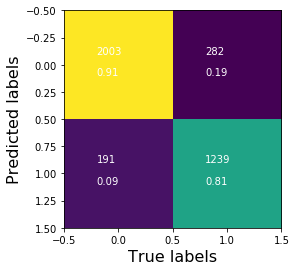

In [77]:
c_mat = confusion_matrix(valid_Ys, valid_y_preds)
plt.imshow(c_mat)
for i, r in enumerate(c_mat):
    for j, c in enumerate(r):
        plt.text(i-0.2, j-0.1, str(c_mat[i, j]), color='w')
        plt.text(i-0.2, j+0.1, "%.2f" % (c_mat[i, j]/c_mat[i].sum()), color='w')
#plt.gca().set_xticks([0, 1, 2, 3])
#plt.gca().set_xticklabels(['GBM', 'IL17', 'IFN', 'Control'])
#plt.gca().set_yticks([0, 1, 2, 3])
#plt.gca().set_yticklabels(['GBM', 'IL17', 'IFN', 'Control'])
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
#plt.savefig('Confusion_matrix_predictions_traj_vectors.png', dpi=300)

In [79]:
from sklearn.metrics import f1_score, accuracy_score
accuracy_score(valid_Ys, valid_y_preds)

0.872678331090175

In [ ]:
# Supp Fig 5
JUNE_data_dir =  '/gpfs/CompMicro/Projects/learningCellState/microglia/data_processed'
JUNE_trajs = pickle.load(open(os.path.join(JUNE_data_dir, 'D_trajectories.pkl'), 'rb'))
JUNE_dats = pickle.load(open(os.path.join(JUNE_data_dir, 'D_latent_space_PCAed.pkl'), 'rb'))

JUNE_traj_PC1_diffs = []
JUNE_traj_PC2_diffs = []
JUNE_base_PC1_diffs = []
JUNE_base_PC2_diffs = []

for t in JUNE_trajs:
    traj_PC1 = JUNE_dats[np.array(JUNE_trajs[t])][:, 0]
    traj_PC2 = JUNE_dats[np.array(JUNE_trajs[t])][:, 1]
    traj_PC1_diff = np.abs(traj_PC1[1:] - traj_PC1[:-1])
    traj_PC2_diff = np.abs(traj_PC2[1:] - traj_PC2[:-1])
    JUNE_traj_PC1_diffs.append(traj_PC1_diff)
    JUNE_traj_PC2_diffs.append(traj_PC2_diff)
    random_PC1 = JUNE_dats[np.random.choice(np.arange(JUNE_dats.shape[0]), 
                                            (len(JUNE_trajs[t]),), 
                                            replace=False), 0]
    random_PC2 = JUNE_dats[np.random.choice(np.arange(JUNE_dats.shape[0]), 
                                            (len(JUNE_trajs[t]),), 
                                            replace=False), 1]
    JUNE_base_PC1_diffs.append(np.abs(random_PC1[1:] - random_PC1[:-1]))
    JUNE_base_PC2_diffs.append(np.abs(random_PC2[1:] - random_PC2[:-1]))
JUNE_traj_PC1_diffs = np.concatenate(JUNE_traj_PC1_diffs)
JUNE_traj_PC2_diffs = np.concatenate(JUNE_traj_PC2_diffs)
JUNE_base_PC1_diffs = np.concatenate(JUNE_base_PC1_diffs)
JUNE_base_PC2_diffs = np.concatenate(JUNE_base_PC2_diffs)

NOVEMBER_traj_PC1_diffs = []
NOVEMBER_traj_PC2_diffs = []
NOVEMBER_base_PC1_diffs = []
NOVEMBER_base_PC2_diffs = []
for t in traj_inds:
    well = t[:2]
    traj_PC1 = dats[well][np.array(traj_inds[t])][:, 0]
    traj_PC2 = dats[well][np.array(traj_inds[t])][:, 1]
    traj_PC1_diff = np.abs(traj_PC1[1:] - traj_PC1[:-1])
    traj_PC2_diff = np.abs(traj_PC2[1:] - traj_PC2[:-1])
    NOVEMBER_traj_PC1_diffs.append(traj_PC1_diff)
    NOVEMBER_traj_PC2_diffs.append(traj_PC2_diff)
    random_PC1 = dats[well][np.random.choice(np.arange(dats[well].shape[0]), 
                                             (len(traj_inds[t]),), 
                                             replace=False), 0]
    random_PC2 = dats[well][np.random.choice(np.arange(dats[well].shape[0]), 
                                             (len(traj_inds[t]),), 
                                             replace=False), 1]
    NOVEMBER_base_PC1_diffs.append(np.abs(random_PC1[1:] - random_PC1[:-1]))
    NOVEMBER_base_PC2_diffs.append(np.abs(random_PC2[1:] - random_PC2[:-1]))
NOVEMBER_traj_PC1_diffs = np.concatenate(NOVEMBER_traj_PC1_diffs)
NOVEMBER_traj_PC2_diffs = np.concatenate(NOVEMBER_traj_PC2_diffs)
NOVEMBER_base_PC1_diffs = np.concatenate(NOVEMBER_base_PC1_diffs)
NOVEMBER_base_PC2_diffs = np.concatenate(NOVEMBER_base_PC2_diffs)

In [ ]:

line_JUNE = np.histogram(JUNE_traj_PC1_diffs, bins=np.arange(0, 8, 0.2), density=True)
line_NOVEMBER = np.histogram(NOVEMBER_traj_PC1_diffs, bins=np.arange(0, 8, 0.2), density=True)
line_base_JUNE = np.histogram(JUNE_base_PC1_diffs, bins=np.arange(0, 8, 0.2), density=True)
line_base_NOVEMBER = np.histogram(NOVEMBER_base_PC1_diffs, bins=np.arange(0, 8, 0.2), density=True)

plt.clf()
plt.bar(line_JUNE[1][:-1]+0.1-0.06, line_JUNE[0], width=0.06, color=matplotlib.cm.get_cmap('Blues')(0.6), label='Train Set Trajectories')
plt.bar(line_JUNE[1][:-1]+0.1+0.00, line_base_JUNE[0], width=0.06, color=matplotlib.cm.get_cmap('Greys')(0.5), label='Random Baseline')
plt.legend(fontsize=16)
plt.xlabel('PC1 diff', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.savefig("figS5_JUNE_PC1.eps")

plt.clf()
plt.bar(line_JUNE[1][:-1]+0.1-0.06, line_NOVEMBER[0], width=0.06, color=matplotlib.cm.get_cmap('Reds')(0.6), label='Test Set Trajectories')
plt.bar(line_JUNE[1][:-1]+0.1+0.00, line_base_NOVEMBER[0], width=0.06, color=matplotlib.cm.get_cmap('Greys')(0.5), label='Random Baseline')
plt.legend(fontsize=16)
plt.xlabel('PC1 diff', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.savefig("figS5_NOVEMBER_PC1.eps")


line_JUNE = np.histogram(JUNE_traj_PC2_diffs, bins=np.arange(0, 8, 0.2), density=True)
line_NOVEMBER = np.histogram(NOVEMBER_traj_PC2_diffs, bins=np.arange(0, 8, 0.2), density=True)
line_base_JUNE = np.histogram(JUNE_base_PC2_diffs, bins=np.arange(0, 8, 0.2), density=True)
line_base_NOVEMBER = np.histogram(NOVEMBER_base_PC2_diffs, bins=np.arange(0, 8, 0.2), density=True)

plt.clf()
plt.bar(line_JUNE[1][:-1]+0.1-0.06, line_JUNE[0], width=0.06, color=matplotlib.cm.get_cmap('Blues')(0.6), label='Train Set Trajectories')
plt.bar(line_JUNE[1][:-1]+0.1+0.00, line_base_JUNE[0], width=0.06, color=matplotlib.cm.get_cmap('Greys')(0.5), label='Random Baseline')
plt.legend(fontsize=16)
plt.xlabel('PC2 diff', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.savefig("figS5_JUNE_PC2.eps")

plt.clf()
plt.bar(line_JUNE[1][:-1]+0.1-0.06, line_NOVEMBER[0], width=0.06, color=matplotlib.cm.get_cmap('Reds')(0.6), label='Test Set Trajectories')
plt.bar(line_JUNE[1][:-1]+0.1+0.00, line_base_NOVEMBER[0], width=0.06, color=matplotlib.cm.get_cmap('Greys')(0.5), label='Random Baseline')
plt.legend(fontsize=16)
plt.xlabel('PC2 diff', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.savefig("figS5_NOVEMBER_PC2.eps")

In [ ]:
# Supp Fig 2
# Scatter plot between PC1 and size
sizes = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_sizes.pkl'), 'rb'))
densities = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_intensities.pkl'), 'rb'))

all_fs = sum([fs[w] for w in wells], [])
ss = np.log(np.array([sizes[f] for f in all_fs]))
ds = np.array([densities[f][0][2] for f in all_fs])

df = {'PC1': np.concatenate([patch_PC1[w] for w in wells]),
      'PC2': np.concatenate([patch_PC2[w] for w in wells]),
      'Size': ss,
      'Peak Phase': ds}

from scipy.stats import spearmanr
print(spearmanr(df['Peak Phase'], df['PC2']))
print(spearmanr(df['Size'], df['PC1']))
print(spearmanr(df['Size'], df['PC2']))

In [ ]:

sns.set_style('white')
bins_y = np.linspace(6, 9.3, 20)
bins_x = np.linspace(-6, 6, 20)
plt.clf()
g = sns.JointGrid(x='PC1', y='Size', data=df, ylim=(6, 9.3), xlim=(-6, 6))
_ = g.ax_marg_x.hist(df['PC1'], bins=bins_x, color=matplotlib.cm.get_cmap('Blues')(0.5))
_ = g.ax_marg_y.hist(df['Size'], bins=bins_y, orientation='horizontal', color=matplotlib.cm.get_cmap('Blues')(0.5))
g.plot_joint(plt.hexbin, cmap="Blues")
y_ticks = np.array([500, 1000, 2000, 4000, 8000])
g.ax_joint.set_yticks(np.log(y_ticks))
g.ax_joint.set_yticklabels(y_ticks)
g.set_axis_labels('PC1', 'Size', fontsize=16)
plt.tight_layout()
plt.savefig('NOVEMBER_joint_density_PC1_size.eps')
#plt.savefig('/home/michaelwu/figs/supp_fig2_PC1_size.png', dpi=300)

sns.set_style('white')
bins_y = np.linspace(0.52, 0.8, 20)
bins_x = np.linspace(-3, 8, 20)
plt.clf()
g = sns.JointGrid(x='PC2', y='Peak Phase', data=df, ylim=(0.52, 0.8), xlim=(-3, 8))
_ = g.ax_marg_x.hist(df['PC2'], bins=bins_x, color=matplotlib.cm.get_cmap('Reds')(0.5))
_ = g.ax_marg_y.hist(df['Peak Phase'], bins=bins_y, orientation='horizontal', color=matplotlib.cm.get_cmap('Reds')(0.5))
g.plot_joint(plt.hexbin, cmap="Reds")
g.set_axis_labels('PC2', 'Peak Phase', fontsize=16)
plt.tight_layout()
plt.savefig('NOVEMBER_joint_density_PC2_density.eps')
# plt.savefig('/home/michaelwu/figs/supp_fig2_PC2_density.png', dpi=300)

In [ ]:
# Supp Fig 4
from scipy.stats import spearmanr, pearsonr
sizes = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_sizes.pkl'), 'rb'))
densities = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_intensities.pkl'), 'rb'))
aps_nr = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_aspect_ratios_nr.pkl'), 'rb'))
aps = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_aspect_ratios.pkl'), 'rb'))

PCs = [np.concatenate([dats[well][:, i] for well in sorted(wells_)]) for i in range(6)]
all_fs = sum([fs[w] for w in sorted(wells_)], [])
Properties = [[np.log(sizes[f]) for f in all_fs],
              [densities[f][0][2] for f in all_fs],
              [densities[f][1][2] for f in all_fs],
              [aps_nr[f][0]/aps_nr[f][1] for f in all_fs],
              [aps[f][1] if aps[f][1] > 0 else aps[f][1] + np.pi for f in all_fs]]


In [ ]:
sr_mat = np.zeros((len(PCs), len(Properties)))
pr_mat = np.zeros((len(PCs), len(Properties)))
for i, PC in enumerate(PCs):
  for j, prop in enumerate(Properties):
    sr_mat[i, j] = spearmanr(PC, prop).correlation
    pr_mat[i, j] = pearsonr(PC, prop)[0]

plt.clf()
fig, ax = plt.subplots()
cmap = matplotlib.cm.get_cmap('RdBu')
im = ax.imshow(np.transpose(sr_mat), cmap=cmap, vmin=-1.5, vmax=1.5)

ax.set_xticks(np.arange(len(PCs)))
ax.set_yticks(np.arange(len(Properties)))
ax.set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
ax.set_yticklabels(['Size', 'Peak Phase', 'Peak Retardance', 'Aspect Ratio', 'Angle (Long axis)'])
for i in range(len(PCs)):
  for j in range(len(Properties)):
    text = ax.text(i, j, "%.2f" % sr_mat[i, j], ha="center", va="center", color="k")
plt.tight_layout()
# plt.show()
plt.savefig('NOVEMBER_correlations.eps')
plt.savefig('NOVEMBER_correlations.png', dpi=300)

In [ ]:
# Supp Fig 7
JUNE_data_dir =  '/gpfs/CompMicro/Projects/learningCellState/microglia/data_processed'
JUNE_dats = pickle.load(open(os.path.join(JUNE_data_dir, 'D_latent_space_PCAed.pkl'), 'rb'))
JUNE_fs = sorted(pickle.load(open(os.path.join(JUNE_data_dir, 'D_file_paths.pkl'), 'rb')))
JUNE_sizes = pickle.load(open('/gpfs/CompMicro/Projects/CellVAE/Data/EncodedSizes.pkl', 'rb'))
ss = [JUNE_sizes[f][0] for f in JUNE_fs]
cmap = matplotlib.cm.get_cmap('BuPu')  
range_min = np.log(min(ss))
range_max = np.log(max(ss))
JUNE_colors = [cmap(((np.log(s) - range_min)/(range_max - range_min))**1.5) for s in ss]

NOVEMBER_dats = np.concatenate([dats[w] for w in sorted(wells_)])
NOVEMBER_fs = np.concatenate([fs[w] for w in sorted(wells_)])
NOVEMBER_sizes = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_sizes.pkl'), 'rb'))
ss = [NOVEMBER_sizes[f] for f in NOVEMBER_fs]
NOVEMBER_colors = [cmap(((np.log(s) - range_min)/(range_max - range_min))**1.5) for s in ss]

with open('temp_save.pkl', 'wb') as f:
    pickle.dump([JUNE_dats, JUNE_colors, NOVEMBER_dats, NOVEMBER_colors], f)
    
# Below need to be run on x86 linux
import umap
import matplotlib.pyplot as plt
import pickle
JUNE_dats, JUNE_colors, NOVEMBER_dats, NOVEMBER_colors = pickle.load(open('temp_save.pkl', 'rb'))
reducer = umap.UMAP()
JUNE_embedding = reducer.fit_transform(JUNE_dats)
NOVEMBER_embedding = reducer.transform(NOVEMBER_dats)
plt.clf()
plt.scatter(JUNE_embedding[:, 0], JUNE_embedding[:, 1], c=JUNE_colors, s=0.5, edgecolors='none')
plt.xlim(-6, 7)
plt.ylim(-7, 7.5)
plt.savefig('JUNE_UMAP.eps')
plt.savefig('JUNE_UMAP.png', dpi=300)
plt.clf()
plt.scatter(NOVEMBER_embedding[:, 0], NOVEMBER_embedding[:, 1], c=NOVEMBER_colors, s=0.5, edgecolors='none')
plt.xlim(-6, 7)
plt.ylim(-7, 7.5)
plt.savefig('NOVEMBER_UMAP.eps')
plt.savefig('NOVEMBER_UMAP.png', dpi=300)

In [28]:
NOVEMBER_dats = np.concatenate([dats[w] for w in sorted(wells_)])
NOVEMBER_fs = np.concatenate([fs[w] for w in sorted(wells_)])
NOVEMBER_sizes = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_sizes.pkl'), 'rb'))
ss = [NOVEMBER_sizes[f] for f in NOVEMBER_fs]
cmap = matplotlib.cm.get_cmap('BuPu')
range_min = np.log(min(ss))
range_max = np.log(max(ss))
NOVEMBER_colors = [cmap(((np.log(s) - range_min)/(range_max - range_min))**1.5) for s in ss]

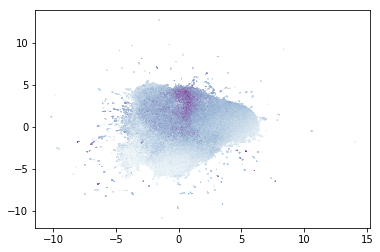

In [80]:
import umap
import matplotlib.pyplot as plt
import pickle
#reducer = umap.UMAP()
#NOVEMBER_embedding = reducer.fit_transform(NOVEMBER_dats)
plt.clf()
plt.scatter(NOVEMBER_embedding[:, 0], NOVEMBER_embedding[:, 1], c=NOVEMBER_colors, s=0.5, edgecolors='none')
plt.show()
#plt.xlim(-6, 7)
#plt.ylim(-7, 7.5)
#plt.savefig('NOVEMBER_UMAP.eps')
#plt.savefig('NOVEMBER_UMAP.png', dpi=300)

In [ ]:
# Extra data on test set reconstruction error
model = VQ_VAE(alpha=0.0005, gpu=True)
model = model.cuda()
model.load_state_dict(torch.load('HiddenStateExtractor/save_0005_bkp4.pt'))

test_r_losses = []
for k in np.random.choice(list(all_patches.keys()), (5000,), replace=False):
  sample = all_patches[k]
  sample = sample.cuda()
  output, loss = model.forward(sample)
  r_loss = loss['recon_loss']
  test_r_losses.append(r_loss.data.cpu().numpy())

print(np.mean(test_r_losses))
print(np.std(test_r_losses))